In [1]:
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras

In [3]:
train_label_length = np.load('/content/drive/My Drive/train_label_length.npy')
train_input_length = np.load('/content/drive/My Drive/train_input_length.npy')
training_img = np.load('/content/drive/My Drive/training_img.npy')
train_padded_txt = np.load('/content/drive/My Drive/train_padded_txt.npy')
max_label_len = np.load('/content/drive/My Drive/max_label_len.npy')

In [ ]:
print(train_label_length.shape)
print(train_input_length.shape)
print(training_img.shape)
print(train_padded_txt.shape)

In [13]:
inputs = Input(shape=(32,128,1))
s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(s)
conv_1 = Dropout(0.25)(conv_1)
conv_1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_1)
conv_2= BatchNormalization(axis=-1)(conv_2)
conv_2 = Dropout(0.25)(conv_2)
conv_2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(pool_2)
conv_3= BatchNormalization(axis=-1)(conv_3)
conv_3 = Dropout(0.25)(conv_3)
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
conv_4 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 128, 16)       160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 64, 32)       

In [14]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [15]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = keras.optimizers.Adam(lr=0.0005), metrics=['acc'])
 
filepath="/content/drive/My Drive/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [16]:
import matplotlib.pyplot as plt
def display(x,y):

  # load the saved best model weights
  act_model.load_weights('/content/drive/My Drive/best_model.hdf5')
  act_model.save('/content/drive/My Drive/act_model.hdf5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n')    

class DisplayCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global model
    model.save('/content/drive/My Drive/model.h5')
    i = np.random.randint(300000)
    display(training_img[i],train_padded_txt[i])

Exception reporting mode: Verbose
Epoch 1/20
350/350 [==============================] - ETA: 0s - loss: 1.7630 - acc: 0.6993
Epoch 00001: val_loss improved from inf to 1.99343, saving model to /content/drive/My Drive/best_model.hdf5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


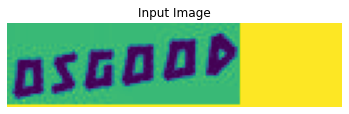

predicted text = osgood

350/350 [==============================] - 269s 769ms/step - loss: 1.7630 - acc: 0.6993 - val_loss: 1.9934 - val_acc: 0.7499
Epoch 2/20
350/350 [==============================] - ETA: 0s - loss: 1.7439 - acc: 0.7012
Epoch 00002: val_loss improved from 1.99343 to 1.96957, saving model to /content/drive/My Drive/best_model.hdf5


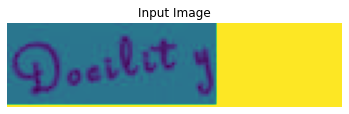

predicted text = Decility

350/350 [==============================] - 265s 757ms/step - loss: 1.7439 - acc: 0.7012 - val_loss: 1.9696 - val_acc: 0.7364
Epoch 3/20
350/350 [==============================] - ETA: 0s - loss: 1.7056 - acc: 0.7068
Epoch 00003: val_loss improved from 1.96957 to 1.94689, saving model to /content/drive/My Drive/best_model.hdf5


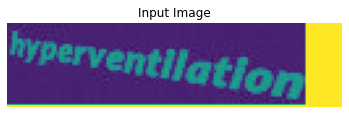

predicted text = hyperventilation

350/350 [==============================] - 265s 757ms/step - loss: 1.7056 - acc: 0.7068 - val_loss: 1.9469 - val_acc: 0.7455
Epoch 4/20
350/350 [==============================] - ETA: 0s - loss: 1.6740 - acc: 0.7097
Epoch 00004: val_loss did not improve from 1.94689


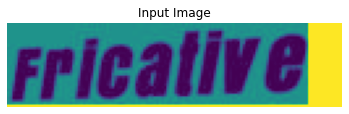

predicted text = Fricalive

350/350 [==============================] - 265s 757ms/step - loss: 1.6740 - acc: 0.7097 - val_loss: 1.9771 - val_acc: 0.7489
Epoch 5/20
350/350 [==============================] - ETA: 0s - loss: 1.6796 - acc: 0.7096
Epoch 00005: val_loss did not improve from 1.94689


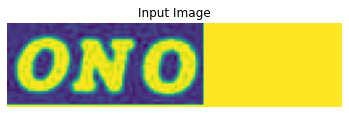

predicted text = ONO

350/350 [==============================] - 264s 756ms/step - loss: 1.6796 - acc: 0.7096 - val_loss: 2.0079 - val_acc: 0.7288
Epoch 6/20
350/350 [==============================] - ETA: 0s - loss: 1.6821 - acc: 0.7076
Epoch 00006: val_loss did not improve from 1.94689


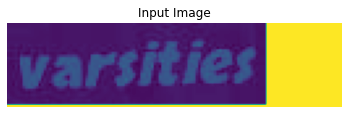

predicted text = varsities

350/350 [==============================] - 264s 754ms/step - loss: 1.6821 - acc: 0.7076 - val_loss: 1.9858 - val_acc: 0.7507
Epoch 7/20
350/350 [==============================] - ETA: 0s - loss: 1.6898 - acc: 0.7083
Epoch 00007: val_loss improved from 1.94689 to 1.94347, saving model to /content/drive/My Drive/best_model.hdf5


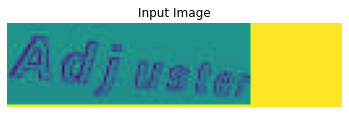

predicted text = Adjuster

350/350 [==============================] - 265s 757ms/step - loss: 1.6898 - acc: 0.7083 - val_loss: 1.9435 - val_acc: 0.7489
Epoch 8/20
350/350 [==============================] - ETA: 0s - loss: 1.6570 - acc: 0.7125
Epoch 00008: val_loss did not improve from 1.94347


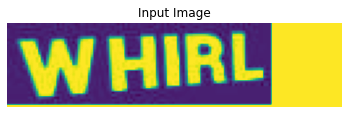

predicted text = WHIRL

350/350 [==============================] - 266s 760ms/step - loss: 1.6570 - acc: 0.7125 - val_loss: 1.9853 - val_acc: 0.7339
Epoch 9/20
350/350 [==============================] - ETA: 0s - loss: 1.6506 - acc: 0.7126
Epoch 00009: val_loss did not improve from 1.94347


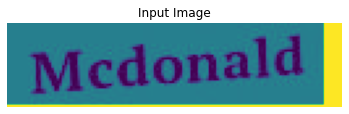

predicted text = Mcdonald

350/350 [==============================] - 264s 755ms/step - loss: 1.6506 - acc: 0.7126 - val_loss: 1.9891 - val_acc: 0.7550
Epoch 10/20
350/350 [==============================] - ETA: 0s - loss: 1.6549 - acc: 0.7123
Epoch 00010: val_loss did not improve from 1.94347


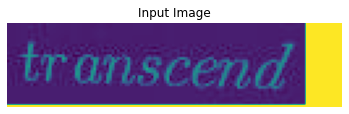

predicted text = transcend

350/350 [==============================] - 263s 752ms/step - loss: 1.6549 - acc: 0.7123 - val_loss: 2.0247 - val_acc: 0.7548
Epoch 11/20
350/350 [==============================] - ETA: 0s - loss: 1.6561 - acc: 0.7121
Epoch 00011: val_loss did not improve from 1.94347


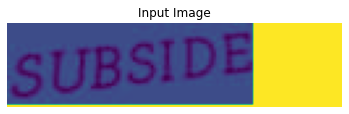

predicted text = SUBSIDE

350/350 [==============================] - 263s 750ms/step - loss: 1.6561 - acc: 0.7121 - val_loss: 2.0285 - val_acc: 0.7571
Epoch 12/20
350/350 [==============================] - ETA: 0s - loss: 1.6647 - acc: 0.7104
Epoch 00012: val_loss did not improve from 1.94347


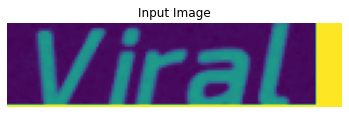

predicted text = Viral

350/350 [==============================] - 264s 755ms/step - loss: 1.6647 - acc: 0.7104 - val_loss: 2.0318 - val_acc: 0.7523
Epoch 13/20
350/350 [==============================] - ETA: 0s - loss: 1.6490 - acc: 0.7128
Epoch 00013: val_loss did not improve from 1.94347


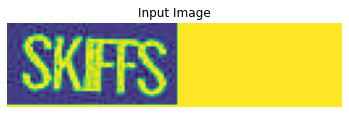

predicted text = SKIFFS

350/350 [==============================] - 264s 756ms/step - loss: 1.6490 - acc: 0.7128 - val_loss: 2.0720 - val_acc: 0.7611
Epoch 14/20
350/350 [==============================] - ETA: 0s - loss: 1.6612 - acc: 0.7117
Epoch 00014: val_loss did not improve from 1.94347


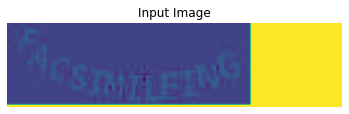

predicted text = FACSINTLEING

350/350 [==============================] - 267s 762ms/step - loss: 1.6612 - acc: 0.7117 - val_loss: 2.0034 - val_acc: 0.7646
Epoch 15/20
350/350 [==============================] - ETA: 0s - loss: 1.6643 - acc: 0.7113
Epoch 00015: val_loss did not improve from 1.94347


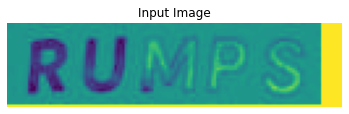

predicted text = RUMPS

350/350 [==============================] - 264s 755ms/step - loss: 1.6643 - acc: 0.7113 - val_loss: 1.9617 - val_acc: 0.7397
Epoch 16/20
350/350 [==============================] - ETA: 0s - loss: 1.7483 - acc: 0.7036
Epoch 00016: val_loss did not improve from 1.94347


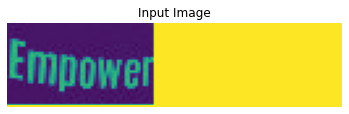

predicted text = Empower

350/350 [==============================] - 265s 758ms/step - loss: 1.7483 - acc: 0.7036 - val_loss: 2.0321 - val_acc: 0.7280
Epoch 17/20
350/350 [==============================] - ETA: 0s - loss: 1.6539 - acc: 0.7125
Epoch 00017: val_loss did not improve from 1.94347


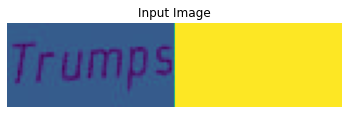

predicted text = Trumps

350/350 [==============================] - 265s 757ms/step - loss: 1.6539 - acc: 0.7125 - val_loss: 2.0100 - val_acc: 0.7431
Epoch 18/20
 19/350 [>.............................] - ETA: 3:43 - loss: 1.5839 - acc: 0.7158

In [ ]:
%xmode Verbose

batch_size = 1026
epochs = 20

callbacks_list = [checkpoint, DisplayCallback()]

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length]
          , y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_split = 0.08,
          verbose = 1,
          callbacks = callbacks_list )

model.save("/content/drive/My Drive/best_model.hdf5")